In [4]:
%pip install -q -r requirements.txt

^C
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential, Model
from onedrivedownloader import download
import os
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import PIL
import datetime
import py7zr
import requests
from tensorboard.plugins.hparams import api as hp
import visualkeras

image_w = 128
image_h = 128
batch_s = 16

# Definition and visualisation of our models 

## Model 1
In the autoencoder below, we try adding a convolution layer with pooling in the encoder __AND__ the decoder.

We then have 4 convolution layers in the encoder, each with the following number of filters: [`64`, `128`, `256`, `512`].

By increasing the number of layers and filters, we try to capture more complex and detailed features. On the other hand, each pooling layer reduces the spatial resolution of the image. In this case, although it helps us, there's a risk of losing fine details such as patterns. This can affect the quality of our denoising.

What's more, the model's complexity will slow down training, as we also increase computational requirements.

The final risk with such an architecture is that, with our reduced dataset, the model has a high chance of overfitting.

In [4]:
def build_dae_4l(input_shape=(128, 128, 3)):
    # Encoder
    input_img = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x) 
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  

    # Decoder
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x) 
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x) 
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x) 
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    return autoencoder

dae_4l = build_dae_4l(input_shape=(image_h, image_w, 3))
dae_4l.summary()
visualkeras.layered_view(dae_4l, to_file=None, legend=True)

## Model 2

In [5]:
# Build the Denoising Autoencoder (DAE) model with a latent bottleneck
def build_denoising_autoencoder_with_latent(input_shape=(128, 128, 3), latent_dim=10):
    # Encoder
    input_img = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Flatten and add the bottleneck layer
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, activation='relu', name='latent_bottleneck')(x)

    # Decoder
    x = layers.Dense(16 * 16 * 128, activation='relu')(latent)  # Reshape back to match the previous encoder layer
    x = layers.Reshape((16, 16, 128))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    return autoencoder

autoencoder_latent = build_denoising_autoencoder_with_latent(input_shape=(image_h, image_w, 3))
autoencoder_latent.summary()
visualkeras.layered_view(autoencoder_latent, to_file=None, legend=True)

## Model 3
In the following architecture, we seek to capture even more complex information in noisy images. The latter also seeks to reconstruct a noisy version of an image via a series of convolutions in the encoder. However, we subsequently use a convolution transposition operation (`keras.layers.Conv2DTranspose`) in the decoder.

The first layer of this encoder is a classic covolution layer containing 32 filters. However, the second layer is a [batch normalization layer](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739) (`keras.layers.BatchNormalisation`) which will stabilize the training. In fact, this is a technique that will solve certain problems linked to training, such as the [__covariate shift__](https://www.seldon.io/what-is-covariate-shift#:~:text=Covariate%20shift%20occurs%20when%20the,accuracy%20will%20be%20significantly%20lower.).

Batch Normalization normalizes a layer's neuron activations by calculating the __mean__ and __standard deviation__ of activations over a batch of examples. Each neuron in the layer receives inputs that are scaled and refocused, helping to __reduce the variance__ of activations between different layers of the network.

Our encoder also includes 2 convolution layers in which __strides__ will reduce the spatial dimension. These stripes designate the way in which the convolution filter moves over the image. A stride of `(2, 2)` as in our model means that the filter moves 2 pixels each time (horizontally and vertically), instead of 1 pixel. This reduces the size of the image by half after each convolutional layer, without adding any extra computation.

Here we use it instead of pooling, because although pooling layers are useful for reducing dimensionality and computation time, they can lead to information loss and increased complexity. In the case of the architecture you're using, the use of strides enables dimensional reduction while retaining some of the relevant information, which can potentially improve model performance.

The last layer of the encoder passes an encoded representation of the reduced-size image to the decoder, which is made up of convolution transposition layers that work like the inverse of normal convolutions, while increasing the image size with strides (like the upsampling seen previously).

While this architecture contains many positive points, such as the use of Batch Normalization and Strides, a more parametric approach than maxpooling, it also has the weakness of accumulating parameters via convolutions and convolutional transpositions. What's more, the number of layers and their large number of filters will increase the time and complexity of the model.

In [6]:
def build_deeper_denoising_autoencoder(input_shape=(128, 128, 3)):
    input_img = layers.Input(shape=input_shape)
    
    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    encoded = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    
    # Decoder
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(encoded)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    return autoencoder

# Compile the model as before
deeper_autoencoder = build_deeper_denoising_autoencoder(input_shape=(image_h, image_w, 3))
deeper_autoencoder.summary()
visualkeras.layered_view(deeper_autoencoder, to_file=None, legend=True)

## VAE Architecture from Model 14 to 18## Model 4

In [7]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Sequential([
            layers.InputLayer(input_shape=(image_h, image_w, 3)),
            layers.Conv2D(32, 3, activation='relu', padding='same'),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 3, activation='relu', padding='same'),
            layers.MaxPooling2D(),
            layers.Conv2D(128, 3, activation='relu', padding='same'),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(latent_dim + latent_dim),  # Mu and log_var
        ])

        # Modification du décodeur pour produire des images de 128x128
        self.decoder = Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(16 * 16 * 128, activation='relu'),
            layers.Reshape((16, 16, 128)),
            layers.Conv2DTranspose(128, 3, activation='relu', padding='same'),
            layers.UpSampling2D(),
            layers.Conv2DTranspose(64, 3, activation='relu', padding='same'),
            layers.UpSampling2D(),
            layers.Conv2DTranspose(32, 3, activation='relu', padding='same'),
            layers.UpSampling2D(),  # Add this line to upsample to 128x128
            layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same'),  # Sortie de taille 128x128
        ])

    def encode(self, x):
        mu_logvar = self.encoder(x)
        mu, log_var = tf.split(mu_logvar, num_or_size_splits=2, axis=1)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        eps = tf.random.normal(shape=tf.shape(mu))
        return mu + tf.exp(log_var * 0.5) * eps

    def decode(self, z):
        return self.decoder(z)

    def call(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        y_pred = self.decode(z)
        loss = self.vae_loss(x, y_pred, mu, log_var)  # Calculer la perte ici
        self.add_loss(loss)  # Ajouter la perte au modèle
        return y_pred

    def vae_loss(self, y_true, y_pred, mu, log_var):
        reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, y_pred))
        kl_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
        return reconstruction_loss + kl_loss

# Création et entraînement du VAE
latent_dim = 64  # Dimension de l'espace latent
vae = VAE(latent_dim)

# Compile le modèle
optimizer = tf.keras.optimizers.Adam()
vae.compile(optimizer=optimizer, metrics=[psnr_metric])  # Retirez la perte ici
def build_denoising_autoencoder_with_pooling(input_shape=(128, 128, 3)):
    input_img = layers.Input(shape=input_shape)
    
    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # Pooling layer added here
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    encoded = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    
    # Decoder
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(encoded)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # Upsampling layer added here
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    return autoencoder

# Compile the model as before
deeper_autoencoder_pool = build_denoising_autoencoder_with_pooling(input_shape=(image_h, image_w, 3))
deeper_autoencoder_pool.summary()
visualkeras.layered_view(deeper_autoencoder_pool, to_file=None, legend=True)

## DAE Architecture From Model 7 to Model 14

In [8]:
# Build the Denoising Autoencoder (DAE) model
def build_denoising_autoencoder(input_shape=(128, 128, 3)):
    # Encoder
    input_img = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    return autoencoderdef build_autoencoder_3l_more_filters(input_shape=(128, 128, 3)):
    # Encoder
    input_img = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    return autoencoder

autoencoder_3l_more_filters = build_autoencoder_3l_more_filters(input_shape=(image_h, image_w, 3))
autoencoder_3l_more_filters.summary()
visualkeras.layered_view(autoencoder_3l_more_filters, to_file=None, legend=True)

## Model 6
The following model is also based on the classic architecture of an autoencoder, with an encoder and decoder that extract features to reduce the dimensionality of the image before reconstructing it.

It is composed of convolution layers to extract features. Each layer has an increasing number of filters, enabling increasingly complex features to be learned. Each of these layers will be followed by a MaxPooling layer to reduce the feature size by 2. This will reduce the amount of data to be processed while retaining the most significant features.

However, unlike the first model, these layers will be interspersed with BatchNormalization layers to stabilize training and reduce the risk of overlearning, as well as layers using the __ReLu__ activation function (`keras.layers.Activation`). This makes it possible to capture non-linearities in the data.

As before, the decoder is made up of deconvulsion layers (UpSampling) and convolutions, but this time with ReLU activation. Each convolution layer in the decoder is followed by Batch Normalization and ReLU, which improves the network's ability to learn details during reconstruction.

Repeated use of Batch Normalization helps to make training more stable and faster, which is particularly useful for autoencoders. However, the architecture is relatively complex, with many layers. If the dataset is small or not very varied, this can increase the risk of overlearning.

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_60 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization_8 (Bat  (None, 128, 128, 64)      256       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_61 (Conv2D)          (None, 64, 64, 128)       7385

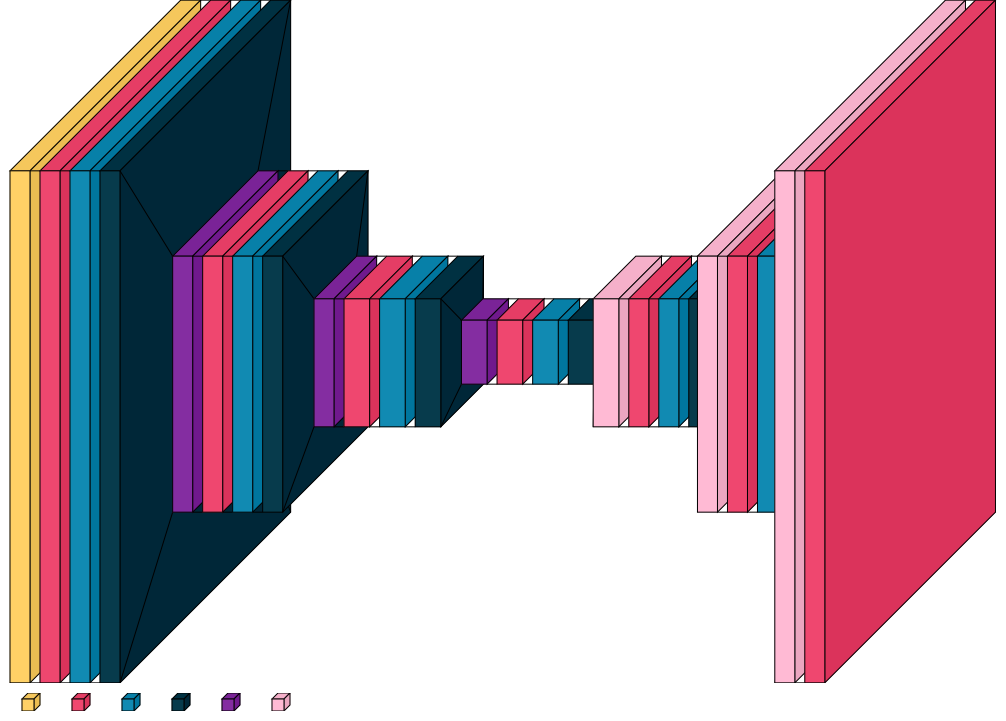

In [10]:
def build_denoising_autoencoder_batch_norm(input_shape=(128, 128, 3)):
    # Encoder
    input_img = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(64, (3, 3), padding='same')(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(256, (3, 3), padding='same')(encoded)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.UpSampling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.UpSampling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.UpSampling2D((2, 2))(x)

    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    return autoencoder

# Build and compile the model
autoencoder_norm = build_denoising_autoencoder_batch_norm(input_shape=(128, 128, 3))
autoencoder_norm.summary()

visualkeras.layered_view(autoencoder_norm, to_file=None, legend=True)